In [2]:
import numpy as np
from sklearn.decomposition import FactorAnalysis
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.size'] = 14

from charlieTools.nat_sounds_ms.decoding import load_site

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-03-13 041934.log


In [3]:
X, sp_bins, X_pup, pup_mask, epochs = load_site(site="AMT020a", batch=331, regress_pupil=False, use_xforms=False, return_epoch_list=True)
# note -- see cache_dprime.py for how to convert "epochs" into actual epoch / bin names for each of the epochs / bins here, if we need to recover the stimulus

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/331/AMT020a_00f577ceb4f996132b73d081720e2cf5c38663f4.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
[root INFO] Extracting cellids: ['AMT020a-02-1', 'AMT020a-04-1', 'AMT020a-07-1', 'AMT020a-08-1', 'AMT020a-09-1', 'AMT020a-11-1', 'AMT020a-12-1', 'AMT020a-13-1', 'AMT020a-16-1', 'AMT020a-16-2', 'AMT020a-17-1', 'AMT020a-17-2', 'AMT020a-22-2', 'AMT020a-22-3', 'AMT020a-24-5', 'AMT020a-24-6', 'AMT020a-25-2', 'AMT020a-25-3', 'AMT020a-26-1', 'AMT020a-26-2', 'AMT020a-27-3', 'AMT020a-28-3', 'AMT020a-28-4

In [4]:
# select a stimulus and fit model for different n components
nstim = X.shape[-1] * X.shape[-2]
Xfa = X.reshape(X.shape[0], X.shape[1], nstim)
nfold = 5
LL = np.zeros((nstim, 10, nfold))
for stim in range(nstim):
    _Xfa = Xfa[:, :, stim]
    for ii in np.arange(1, LL.shape[1]+1):
        fa = FactorAnalysis(n_components=ii, random_state=0) # init model
        np.random.seed(123)
        for nf in range(nfold):
            val = np.random.choice(np.arange(0, _Xfa.shape[1]), int(_Xfa.shape[-1] / nfold), replace=False)
            fit = [x for x in np.arange(0, _Xfa.shape[1]) if x not in val]
            fa.fit(_Xfa[:, fit].T) # fit model
            # Get LL score
            LL[stim, ii-1, nf] = fa.score(_Xfa[:, val].T)

Text(0, 0.5, 'LL')

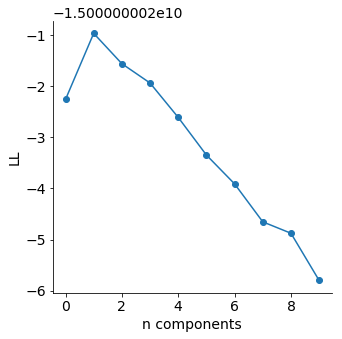

In [5]:
# plot LL vs. components to select dimensionality
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(LL[1, :, :].mean(axis=-1), "-o")
ax.set_xlabel("n components")
ax.set_ylabel("LL")

In [6]:
# measure change in dimensionality, %sv, loading sim, across jackknifes
def get_dim(LL):
    try:
        return argrelextrema(LL, np.greater)[0][0]+1
    except:
        return np.argmax(LL)+1

def get_sv(model):
    sig_shared = (model.components_.T @ model.components_) # rank n_components cov matrix
    full_cov_pred = sig_shared + np.diag(model.noise_variance_)
    # % shared variance
    # per neuron
    pn = np.diag(sig_shared) / np.diag(full_cov_pred)
    # average
    sv = np.mean(pn)
    return sv

def sigma_shared(model):
    return (model.components_.T @ model.components_)

def get_loading_similarity(model):
    # loading similarity
    loading = model.components_[0, :]
    loading /= np.linalg.norm(loading)
    load_sim = 1 - (np.var(loading) / (1 / len(loading)))
    return load_sim

def get_dim95(model):
    """
    number of dims to explain 95% of shared var
    """
    ss = sigma_shared(model)
    evals, _ = np.linalg.eig(ss)
    evals = evals / sum(evals)
    return np.argwhere(np.cumsum(evals)>=0.95)[0][0]+1

In [7]:
# fit all stim together, after subtracting psth
# "special" cross-validation -- fitting individual stims doesn't work, not enough data
# instead, leave-one-stim out fitting to find dims that are shared / stimulus-independent
nstim = X.shape[-1] * X.shape[-2]
Xsub = (X - X.mean(axis=1, keepdims=True))
Xfa = Xsub.reshape(X.shape[0], X.shape[1], nstim)
pm = pup_mask.reshape(pup_mask.shape[0], pup_mask.shape[1], nstim)
#pm = pm[:, np.random.choice(range(pup_mask.shape[1]), pup_mask.shape[1], replace=False), :]
nfold = nstim
LL = np.zeros((20, nfold))
LL_small = np.zeros((20, nfold))
LL_large = np.zeros((20, nfold))
for ii in np.arange(1, LL.shape[0]+1):
    print(f"{ii} / {LL.shape[0]}")
    fa = FactorAnalysis(n_components=ii, random_state=0) # init model
    for nf in range(nfold):
        fit = [x for x in np.arange(0, nstim) if x != nf]

        # fit all data
        fa.fit(Xfa[:, :, fit].reshape(Xfa.shape[0], -1).T) # fit model
        # Get LL score
        LL[ii-1, nf] = fa.score(Xfa[:, :, nf].T)

        # fit large pupil
        fa.fit(Xfa[:, :, fit][:, pm[0, :, fit].T].reshape(Xfa.shape[0], -1).T) # fit model 
        LL_large[ii-1, nf] = fa.score(Xfa[:, pm[0, :, nf], nf].T)

        # fit small pupil
        fa.fit(Xfa[:, :, fit][:, pm[0, :, fit].T==False].reshape(Xfa.shape[0], -1).T) # fit model 
        LL_small[ii-1, nf] = fa.score(Xfa[:, pm[0, :, nf]==False, nf].T)


1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


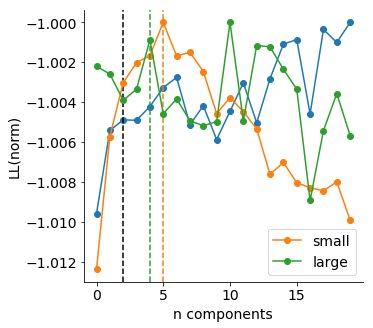

In [8]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(LL.mean(axis=-1) / -max(LL.mean(axis=-1)), "-o")
max_ind = argrelextrema(LL.mean(axis=-1), np.greater)
ax.axvline(max_ind[0][0], linestyle="--", color="k")

ax.plot(LL_small.mean(axis=-1) / -max(LL_small.mean(axis=-1)), "-o", label="small")
sm_max_ind = argrelextrema(LL_small.mean(axis=-1), np.greater)
ax.axvline(sm_max_ind[0][0], linestyle="--", color="tab:orange")

ax.plot(LL_large.mean(axis=-1) / -max(LL_large.mean(axis=-1)), "-o", label="large")
lg_max_ind = argrelextrema(LL_large.mean(axis=-1), np.greater)
ax.axvline(lg_max_ind[0][0], linestyle="--", color="tab:green")

# for i in range(nfold):
#     ax.plot(LL[:, i], alpha=0.5, color="tab:blue")
ax.set_xlabel("n components")
ax.set_ylabel("LL(norm)")
ax.legend()

In [9]:
Xfa.shape

(45, 100, 12)

In [13]:
sp_dim_sem = np.std([get_dim(LL_small[:, i]) for i in range(LL.shape[1])]) / np.sqrt(LL.shape[1])
sp_dim = get_dim(LL_small.mean(axis=-1))
# fit the "best" model
fa = FactorAnalysis(n_components=sp_dim, random_state=0) 
fa.fit(Xfa[:, pm[0]==False].T)
sp_sv = get_sv(fa)
sp_loading_sim = get_loading_similarity(fa)
sp_dim95 = get_dim95(fa)

bp_dim_sem = np.std([get_dim(LL_large[:, i]) for i in range(LL.shape[1])]) / np.sqrt(LL.shape[1])
bp_dim = get_dim(LL_large.mean(axis=-1))
# fit the "best" model
fa = FactorAnalysis(n_components=bp_dim, random_state=0) 
fa.fit(Xfa[:, pm[0]==True].T)
bp_sv = get_sv(fa)
bp_loading_sim = get_loading_similarity(fa)
bp_dim95 = get_dim95(fa)

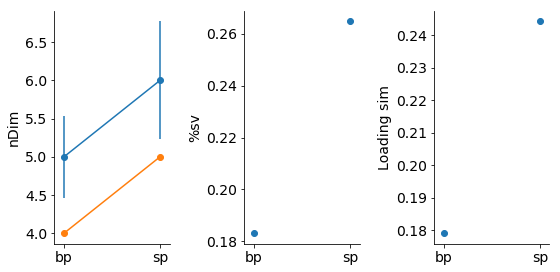

In [14]:
f, ax = plt.subplots(1, 3, figsize=(8, 4))


ax[0].errorbar([0, 1], [bp_dim, sp_dim], yerr=[bp_dim_sem, sp_dim_sem], marker="o")
ax[0].plot([0, 1], [bp_dim95, sp_dim95], marker="o")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["bp", "sp"])
ax[0].set_ylabel("nDim")
ax[0].set_xlim(-0.1, 1.1)

ax[1].plot([0, 1], [bp_sv, sp_sv], "o")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["bp", "sp"])
ax[1].set_ylabel("%sv")
ax[1].set_xlim(-0.1, 1.1)

ax[2].plot([0, 1], [bp_loading_sim, sp_loading_sim], "o")
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(["bp", "sp"])
ax[2].set_ylabel("Loading sim")
ax[2].set_xlim(-0.1, 1.1)

f.tight_layout()

In [61]:
np.std([get_dim(LL_large[:, i]) for i in range(LL.shape[1])]) / np.sqrt(LL.shape[1])

0.30160066804130753

In [16]:
ss = sigma_shared(fa)
evals, _ = np.linalg.eig(ss)

/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


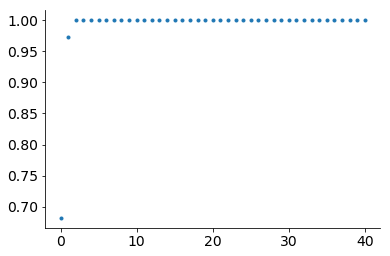

In [18]:
plt.plot(np.cumsum(evals/sum(evals)), ".")